In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
import torch.nn
from torch.functional import F

from tqdm import tqdm
import torch.optim as optim


import matplotlib.pyplot as plt
import os

os.chdir('d:\Python Projects\EVA')

In [2]:
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-14.0, 14.0), fill=(1,)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data',train=False, download=True, transform=test_transforms)


In [4]:
#
SEED = 1

device = 'cuda' if torch.cuda else 'cpu'
print(device)

# for Reproducable results
torch.manual_seed(SEED)

#Setting seed if CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Dataloader Arguments
dataloader_args = dict(shuffle=True, num_workers=4, batch_size=128, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

train_dataloader = DataLoader(train,**dataloader_args)

test_dataloader = DataLoader(test, **dataloader_args)  

cuda


# The Model

In [5]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3,padding=0),  # 26
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.MaxPool2d(2,2), # 12
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0),  # 10
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0),  # 8
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            # nn.MaxPool2d(2,2),  # 7
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 10, 3),  # 6
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(10, 10, 3),  # 4
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(10, 10, 1),  #1
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,456
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 10, 10]           1,450
             ReLU-11           [-1, 10, 10, 10]               0
      BatchNorm2d-12           [-1, 10, 10, 10]              20
          Dropout-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

In [7]:
train_acc = []
test_acc = []
train_losses = []
test_losses = []

def train(model, device, train_dataloader, optimizer, epochs):
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def test(model, device, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.06)
EPOCHS = 15

for epoch in range(EPOCHS):
    print('EPOCH - ', epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_dataloader)

0%|          | 0/469 [00:00<?, ?it/s]EPOCH -  0
Loss=0.16086596250534058 Batch_id=468 Accuracy=87.14: 100%|██████████| 469/469 [00:17<00:00, 26.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0672, Accuracy: 9824/10000 (98.24%)

EPOCH -  1
Loss=0.09701629728078842 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:19<00:00, 24.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0459, Accuracy: 9865/10000 (98.65%)

EPOCH -  2
Loss=0.02791723608970642 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0342, Accuracy: 9902/10000 (99.02%)

EPOCH -  3
Loss=0.09775612503290176 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0296, Accuracy: 9915/10000 (99.15%)

EPOCH -  4
Loss=0.05206570401787758 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [

Text(0.5, 1.0, 'Test Accuracy')

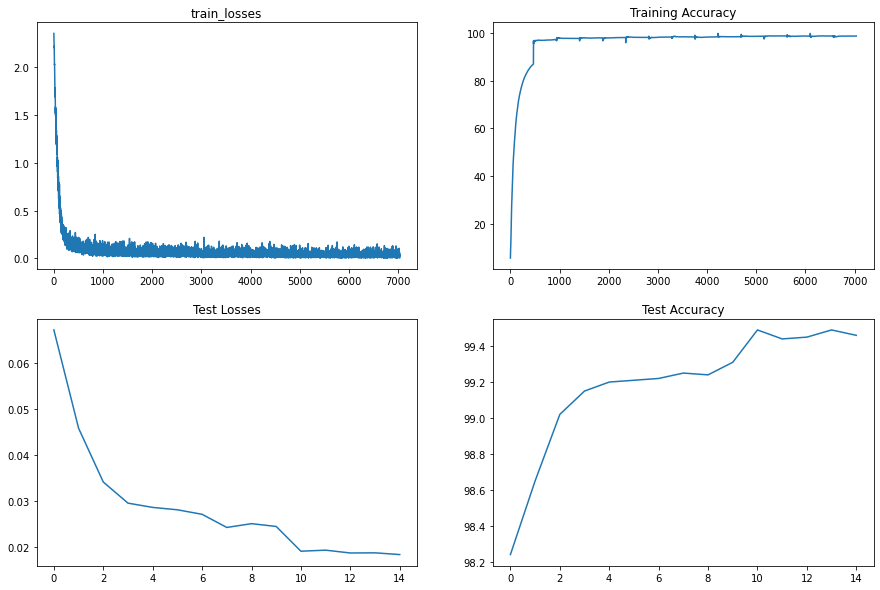

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title('train_losses')
axs[0,1].plot(train_acc)
axs[0,1].set_title('Training Accuracy')
axs[1,0].plot(test_losses)
axs[1,0].set_title('Test Losses')
axs[1,1].plot(test_acc)
axs[1,1].set_title('Test Accuracy')